In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import random
random.seed(42)
import numpy as np
np.random.seed(42)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from sklearn import metrics
from sktime.clustering.k_means import TimeSeriesKMeans
from sktime.clustering.utils.plotting._plot_partitions import plot_cluster_algorithm
from pathlib import Path
import config
from sklearn.model_selection import train_test_split
from preprocessing import dataPreProcess

In [3]:
def read_files(activity):
    dfs = []
    for file in config.DATA_FILES[activity]:
        filepath = Path(config.DATA_FOLDER, activity, file);
        with open(filepath, 'r') as file:
            raw_data = file.readlines()
            dfs.append(dataPreProcess(raw_data))
    dfs = [df.reset_index(drop = True) for df in dfs if not df is None]
    return dfs

In [4]:
activities = ['idle', 'jogging', 'after_exercise', 'exercise']
activity_labels = {'idle': 0, 'jogging': 1, 'after_exercise': 2, 'exercise': 3}

In [5]:
dfs = {}
for activity in activities:
    dfs[activity] = read_files(activity)

There are no valid SPO values, returning None


### Train and Test split

In [6]:
def split_dataframes(df, sample_count):
    dfs = np.array_split(df, range(sample_count, len(df), sample_count), axis = 0)
    dfs = [_df.copy().reset_index(drop = True) for _df in dfs]
    return dfs

In [7]:
def prepare_datasets(dfs, sample_count=20):

    df_labels = {}
    max_series = 0
    for activity in dfs:
        df_labels[activity] = []
        for df in dfs[activity]:
            split_df = split_dataframes(df, sample_count)
            split_df = [_df for _df in split_df if len(_df) == sample_count]
            df_labels[activity].extend([(_df, activity_labels[activity]) for _df in split_df ])
            
        max_series = max(max_series, len(df_labels[activity]))
        
    for activity in df_labels:
        if len(df_labels[activity]) != max_series:
            df_labels[activity].extend(random.choices(df_labels[activity],k = max_series - len(df_labels[activity])))
    
    combined_df_labels = []
    for activity in df_labels:
        combined_df_labels.extend(df_labels[activity])
        
    random.shuffle(combined_df_labels)
    return list(zip(*combined_df_labels))

In [8]:
train_dfs = {}
test_dfs = {}

for activity in dfs:
    test_size = max(1, int(0.3 * len(dfs[activity])))
    train_dfs[activity] = dfs[activity][: len(dfs[activity]) - test_size]
    test_dfs[activity] = dfs[activity][len(dfs[activity]) - test_size:]
    
X_train, y_train = prepare_datasets(train_dfs, sample_count = 40)
X_test, y_test = prepare_datasets(test_dfs, sample_count = 40)

[Text(0.5, 1.0, 'Test data distribution'), Text(0.5, 0, 'Classes')]

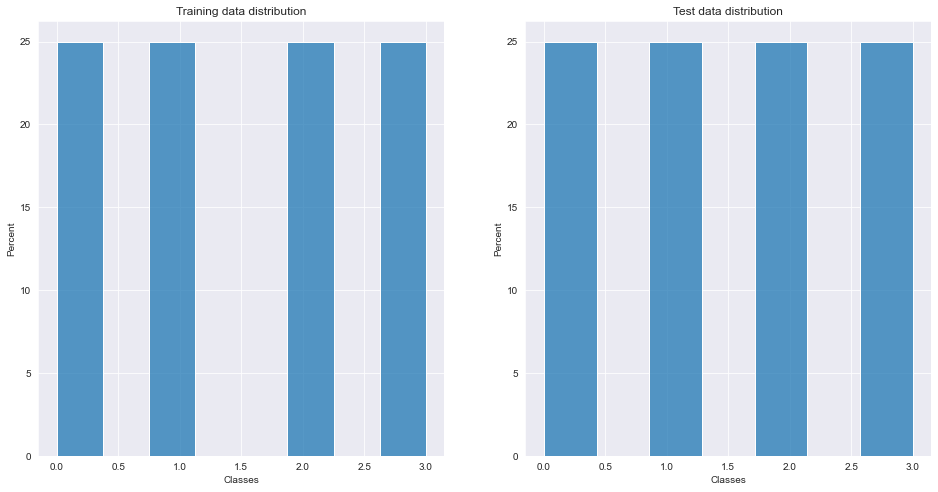

In [15]:
fig, axes = plt.subplots(ncols = 2, figsize = (16, 8))
sns.histplot(ax = axes[0], x = y_train, stat = 'percent').set(title = 'Training data distribution', xlabel = 'Classes')
sns.histplot(ax = axes[1], x = y_test, stat = 'percent').set(title = 'Test data distribution', xlabel = 'Classes')

### Time Series K Means

In [10]:
def get_metric_score(y_true, y_pred):
    homogeneity_score = metrics.homogeneity_score(y_true, y_pred)
    completeness_score = metrics.completeness_score(y_true, y_pred)
    
    return {'homogeneity_score': homogeneity_score, 'completeness_score': completeness_score}

In [11]:
kmeans = TimeSeriesKMeans(
    n_clusters=4,  # Number of desired centers
    init_algorithm="forgy",  # Center initialisation technique
    max_iter=100,  # Maximum number of iterations for refinement on training set
    metric="dtw",  # Distance metric to use
    averaging_method="mean",  # Averaging technique to use
    random_state=1,
)

kmeans.fit(list(X_train))

TimeSeriesKMeans(averaging_method='mean', init_algorithm='forgy', max_iter=100,
                 n_clusters=4, random_state=1)

In [12]:
print('Training metrics:', get_metric_score(list(y_train), kmeans.predict(list(X_train))))

Training metrics: {'homogeneity_score': 0.34589605965497033, 'completeness_score': 0.40664655804342975}


In [13]:
print('Test metrics:', get_metric_score(list(y_test), kmeans.predict(list(X_test))))

Test metrics: {'homogeneity_score': 0.4085835973573986, 'completeness_score': 0.5201737073077491}
